In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# read dataset file

df = pd.read_csv('Euro_6_latest.csv', delimiter=',')

In [2]:
# Remove a funny column called Unnamed
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Remove features with more than 70% missing values
limitPer = len(df) * .70
df = df.dropna(thresh=limitPer, axis=1).copy()


# drop unnecessary columns
df = df.drop(['Transmission','Euro Standard','Testing Scheme','Date of change','WLTP Imperial Low',
               'WLTP Imperial Medium','WLTP Imperial High','WLTP Imperial Extra High',
               'WLTP Imperial Combined','WLTP Imperial Combined (Weighted)' ,
                'Diesel VED Supplement','Emissions NOx [mg/km]',
               'THC Emissions [mg/km]','Noise Level dB(A)'], axis=1).copy()
df.shape

(4657, 18)

In [3]:
print(df['Manual or Automatic'].unique(),'\n')
# Create a new column 'Transmission', assign it a value of Automatic where the 
# first character of Transmission is A
# or Manual if the first letter is M or Electric if first letter is E 
AUTOMATIC = "Automatic"
MANUAL = "Manual"
ELECTRIC = "Electric"
df.loc[df['Manual or Automatic'].str.startswith('A'),'Transmission'] = AUTOMATIC
df.loc[df['Manual or Automatic'].str.startswith('M'),'Transmission'] = MANUAL
df.loc[df['Manual or Automatic'].str.startswith('E'),'Transmission'] = ELECTRIC

['Manual' 'Automatic' 'Electric - Not Applicable'] 



In [5]:
pertrol = ['Petrol','Petrol / LPG']
diesel = ['Diesel']
electric = ['Electricity']
hybrid = ['Electricity / Petrol','Petrol Electric','Diesel Electric','Electricity / Diesel']
#df = df.copy()
df.loc[df['Fuel Type'].isin(pertrol), 'Fuel'] = 'Petrol'
df.loc[df['Fuel Type'].isin(diesel), 'Fuel'] = 'Diesel'
df.loc[df['Fuel Type'].isin(electric), 'Fuel'] = 'Electric'
df.loc[df['Fuel Type'].isin(hybrid), 'Fuel'] = 'Hybrid'

In [6]:
ice = ['Internal Combustion Engine (ICE)']
hybrid = ['Plug-in Hybrid Electric Vehicle (PHEV)',
          'Mild Hybrid Electric Vehicle (MHEV)',
          'Hybrid Electric Vehicle (HEV)','Micro Hybrid']
ev = ['Battery Electric Vehicle (BEV) / Pure Electric Vehicle / Electric Vehicle (EV)']

df.loc[df['Powertrain'].isin(ice), 'PT'] = 'ICE'
df.loc[df['Powertrain'].isin(ev), 'PT'] = 'EV'
df.loc[df['Powertrain'].isin(hybrid), 'PT'] = 'Hybrid'

And we drop the original columns Powertrain, Fuel Type, and Manual or Automatic.

In [7]:
# Drop the old columns
df = df.drop(['Powertrain','Fuel Type','Manual or Automatic'], axis=1)

And rename PT back to Powertrain

In [8]:
df.rename(columns={'PT':'Powertrain'}, inplace=True)

###  2.3 - Handle missing values and zeros

We check missing values in each of the remaining columns

In [9]:
df['Engine Capacity'] = df['Engine Capacity'].fillna(0)

In [10]:
df['Engine Power (PS)'] = df.groupby(['Manufacturer','Model'], sort=False) \
    ['Engine Power (PS)'].apply(lambda x: x.ffill().bfill())

# Same with Engine Power (Kw)
df['Engine Power (Kw)'] = df.groupby(['Manufacturer','Model'], sort=False) \
    ['Engine Power (Kw)'].apply(lambda x: x.ffill().bfill())

Some of the features has many zeros. For example, <i>WLTP Metric Combined (Weighted)</i> and <i>WLTP CO2</i>.<br/>

Let's count how many zeros in WLTP Metric Combined (Weighted) and WLTP CO2 Weighted columns

In [11]:
df = df.drop(['WLTP Metric Combined (Weighted)','WLTP CO2 Weighted'], axis=1).copy()

For the rest of the features, we are going to fill missing values with mean of each column.<br>

We did not replace 0 values with the mean because that is not correct, for example electric cars may have 0 CO emissions.

In [12]:
df['WLTP Metric Combined'].fillna((df['WLTP Metric Combined'].mean()), inplace=True)
df['WLTP Metric Low'].fillna((df['WLTP Metric Low'].mean()), inplace=True)
df['WLTP Metric Medium'].fillna((df['WLTP Metric Medium'].mean()), inplace=True)
df['WLTP Metric High'].fillna((df['WLTP Metric High'].mean()), inplace=True)
df['WLTP Metric Extra High'].fillna((df['WLTP Metric Extra High'].mean()), inplace=True)
df['WLTP CO2'].fillna((df['WLTP CO2'].mean()), inplace=True)
df['Emissions CO [mg/km]'].fillna((df['Emissions CO [mg/km]'].mean()), inplace=True)
df.isnull().sum(axis = 0)

Manufacturer                0
Model                       0
Description                 0
Engine Capacity             0
Engine Power (PS)         177
Engine Power (Kw)          89
WLTP Metric Low             0
WLTP Metric Medium          0
WLTP Metric High            0
WLTP Metric Extra High      0
WLTP Metric Combined        0
WLTP CO2                    0
Emissions CO [mg/km]        0
Transmission                0
Fuel                        0
Powertrain                  0
dtype: int64

There are still 177 missing values in Engine Power (PS) and 89 in Engine Power (Kw). We looked at the original dataset csv file. It turns out those car models have no data. Therefore we are going to drop those models.

In [13]:
df = df.dropna().copy()

In [14]:
dummy_cols = ['Transmission','Fuel','Powertrain']
df_encode = pd.get_dummies(df, columns=dummy_cols).copy()
df_encode = df_encode.drop(['Manufacturer','Model','Description'], axis=1).copy()

First thing we want to do is see what data types do we have now:

In [15]:
df_encode.dtypes

Engine Capacity           float64
Engine Power (PS)         float64
Engine Power (Kw)         float64
WLTP Metric Low           float64
WLTP Metric Medium        float64
WLTP Metric High          float64
WLTP Metric Extra High    float64
WLTP Metric Combined      float64
WLTP CO2                  float64
Emissions CO [mg/km]      float64
Transmission_Automatic      uint8
Transmission_Electric       uint8
Transmission_Manual         uint8
Fuel_Diesel                 uint8
Fuel_Electric               uint8
Fuel_Hybrid                 uint8
Fuel_Petrol                 uint8
Powertrain_EV               uint8
Powertrain_Hybrid           uint8
Powertrain_ICE              uint8
dtype: object

# 5 Identify the input and target variables
Our target variable (y) is 'Emissions CO [mg/km]'

We may use all or subset of the numeric features for the prediction models as input variables or X.

In [19]:
X = df_encode.loc[:, df_encode.columns != 'Emissions CO [mg/km]']
print()
print('X or input variables are:')
print()
print(X.columns.tolist())
y =  df_encode['Emissions CO [mg/km]']


X or input variables are:

['Engine Capacity', 'Engine Power (PS)', 'Engine Power (Kw)', 'WLTP Metric Low', 'WLTP Metric Medium', 'WLTP Metric High', 'WLTP Metric Extra High', 'WLTP Metric Combined', 'WLTP CO2', 'Transmission_Automatic', 'Transmission_Electric', 'Transmission_Manual', 'Fuel_Diesel', 'Fuel_Electric', 'Fuel_Hybrid', 'Fuel_Petrol', 'Powertrain_EV', 'Powertrain_Hybrid', 'Powertrain_ICE']


# 6 Splitting the Data

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)

# Lasso Model Section 

In [120]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import scale
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

First, we investigate the size of each feature weight as function of alpha.

In [121]:
alphas = 10**np.linspace(10,-2,100)*0.5
sc = StandardScaler()
Y_train  = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)
Y_train_s = sc.fit_transform(Y_train.reshape(len(Y_train),1))[:,0]
Y_test_s = sc.transform(Y_test.reshape(len(Y_test),1))[:,0]

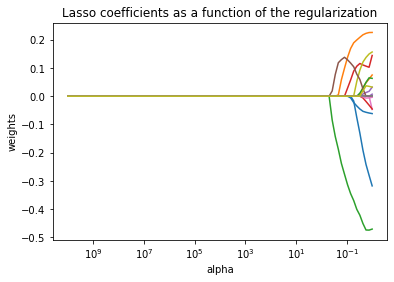

In [151]:
# Initialise the Lasso mode with Normalisation of features as True
#lasso = Lasso(normalize=True)
lasso = Lasso()
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_s, Y_train_s)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

Moving from the left to right in the plot, at first the coefficient estimates approximate towards zero. Then the model starts to have more predictors with high magnitudes of coefficient estimates.

In [123]:
print('The number of nonzero coefficients:',np.count_nonzero(lasso.coef_) + np.count_nonzero(lasso.intercept_))
pd.Series(lasso.coef_, index=X.columns)

The number of nonzero coefficients: 15


Engine Capacity          -0.317497
Engine Power (PS)         0.075032
Engine Power (Kw)         0.063150
WLTP Metric Low           0.144223
WLTP Metric Medium        0.031840
WLTP Metric High         -0.000000
WLTP Metric Extra High   -0.046854
WLTP Metric Combined     -0.000000
WLTP CO2                  0.156511
Transmission_Automatic   -0.000000
Transmission_Electric    -0.061569
Transmission_Manual       0.225749
Fuel_Diesel              -0.470501
Fuel_Electric            -0.045358
Fuel_Hybrid               0.007146
Fuel_Petrol               0.000000
Powertrain_EV            -0.003812
Powertrain_Hybrid        -0.000000
Powertrain_ICE            0.032203
dtype: float64

Next, we need to find the optimal value of alpha to use in our model.<br/>

use LassoCV function to fit the regression model and find the optimal alpha. We also use RepeatedKFold() to evaluate the lasso model.<br/>

We will define a range for alpha from 0 to 1 with increment of 0.01<br/>

In [152]:
# RepeatedKFold for evaluation of the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model with normalize = True so we don't have to scale the features
lassocv = LassoCV(alphas=np.arange(0.01, 1, 0.01), cv=cv, n_jobs=-1)

# Fit the model
lassocv.fit(X_train_s, Y_train_s)
# Best alpha
best_alpha = lassocv.alpha_
print('Best lambda that produced the lowest test MSE = ', best_alpha)
print()
print('Coefficients of the model are \n')
pd.Series(lassocv.coef_, index=X.columns)

Best lambda that produced the lowest test MSE =  0.01

Coefficients of the model are 



Engine Capacity          -0.317497
Engine Power (PS)         0.075032
Engine Power (Kw)         0.063150
WLTP Metric Low           0.144223
WLTP Metric Medium        0.031840
WLTP Metric High         -0.000000
WLTP Metric Extra High   -0.046854
WLTP Metric Combined     -0.000000
WLTP CO2                  0.156511
Transmission_Automatic   -0.000000
Transmission_Electric    -0.061569
Transmission_Manual       0.225749
Fuel_Diesel              -0.470501
Fuel_Electric            -0.045358
Fuel_Hybrid               0.007146
Fuel_Petrol               0.000000
Powertrain_EV            -0.003812
Powertrain_Hybrid        -0.000000
Powertrain_ICE            0.032203
dtype: float64

Now we are going to use the best lambda in our model for prediction

In [153]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.set_params(alpha=alpha)
lasso.fit(X_train_s, Y_train_s)
y_pred = lasso.predict(X_train_s)
MSE = mean_squared_error(Y_train_s, y_pred)
print("Train MSE = " ,MSE)
rMSE = np.sqrt(MSE)

print("Train rMSE = " ,rMSE)

Train MSE =  0.6216156354144254
Train rMSE =  0.7884260494265937


In [154]:
y_pred_t = lasso.predict(X_test_s)
MSE = mean_squared_error(Y_test_s, y_pred_t)
print("Test MSE = " ,MSE)
rMSE = np.sqrt(MSE)

print("Test rMSE = " ,rMSE)

Test MSE =  0.6212261532045529
Test rMSE =  0.7881790108881058


In [141]:
lasso.fit(X_train_s, Y_train_s)
lasso.score(X_test_s, Y_test_s), lasso.score(X_train_s, Y_train_s)

(0.3543272693630334, 0.3708443159323527)